In [1]:
#load packages
import numpy as np
import scipy as sp
import scipy.sparse
import os
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt

### Train/Test Split

In this section, we load the data. Then we check that it is accurate. Then we split the data into four training (80% together) datasets and a test (20%) dataset. Finally, we save the datasets.

In [2]:
# directory with data processed from pgn files
dataDir = '../data/clean'
dataFiles = os.listdir(dataDir)
dataFiles

['xTrain2.npz',
 'xTrain3.npz',
 '2007_stats.pickle',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_1_mat.pickle.gz',
 'xTrain1.npz',
 'xTrain0.npz',
 '.DS_Store',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_2_mat.pickle.gz',
 'yTrain2.npz',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_2_stats.pickle',
 'yTrain3.npz',
 'yTrain1.npz',
 'yTrain0.npz',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_3_stats.pickle',
 '2008_mat.pickle.gz',
 'xTest.npz',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_1_stats.pickle',
 '2009_mat.pickle.gz',
 '2008_stats.pickle',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_0_stats.pickle',
 'yTest.npz',
 '2009_stats.pickle',
 'yTrain.npz',
 'xTrain.npz',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_3_mat.pickle.gz',
 'ficsgamesdb_2006_chess2000_nomovetimes_1519260_0_mat.pickle.gz',
 '2007_mat.pickle.gz']

In [3]:
# load data into memory
boardList = []
resultList = []
statsList = []

for dataFile in dataFiles:
    if dataFile.endswith('.gz'):
        with gzip.open(os.path.join(dataDir,dataFile), 'rb') as f:
            pickledList = f.read()
            boardMat, resultMat = pickle.loads(pickledList) #matrix of board positions, matrix of game results
            boardList.append(boardMat)
            resultList.append(resultMat)    
    
    elif dataFile.endswith('.pickle'):
        stats = pd.read_pickle(os.path.join(dataDir,dataFile))
        statsList.append(stats)
        
#Data check that results vector and board matrix are in sync

s = 0
for i in range(len(boardList)):
    s = s + np.sum(boardList[i].shape[0] == resultList[i].shape[0])
print(len(boardList) - s)
#if not zero then there is a problem with the parsing of the data.
#need to look into parse data code and raw data

0


In [4]:
# combine list of matrices and into one matrix

boards = scipy.sparse.vstack(boardList)
results = np.concatenate(resultList)
stats = pd.concat(statsList)

del [boardList, resultList, statsList]

In [5]:
# memory usage in GiB
dataGiB = boards.nnz * boards.dtype.itemsize / (1024**3)
colGiB = boards.indices.shape[0] * boards.indices.dtype.itemsize / (1024**3)
rowGiB = boards.indptr.shape[0] * boards.indptr.dtype.itemsize / (1024**3)
print('Boards total GiB: ' + str(dataGiB + colGiB + rowGiB))

dataGiB = results.shape[0] * results.dtype.itemsize / (1024**3)
print('Results total GiB: ' + str(dataGiB))

print('Number of Board Positions: ' + str(boards.shape[0]))

Boards total GiB: 10.178316971287131
Results total GiB: 0.08962979912757874
Number of Board Positions: 96239264


In [12]:
# train test split for full data
from sklearn.utils import shuffle as skshuffle
xTrain, yTrain = skshuffle(boards, results)
del [boards, results]

In [ ]:
# train test split
chunks = os.cpu_count()
from sklearn.model_selection import train_test_split

# 20% to test and 80% to train
xTrain, xTest, yTrain, yTest = train_test_split(boards, results, train_size = 0.8)
# Subdivide train into # of cores pieces

del [boards, results]

In [ ]:
chunks = os.cpu_count()
interval = xTrain.shape[0] // chunks
xTrain_ = []
yTrain_ = []
for i in range(chunks):
    if i == chunks:
        xTrain_.append(xTrain[interval * i:-1])
        yTrain_.append(yTrain[interval * i:-1])
    else:
        xTrain_.append(xTrain[interval * i:interval * (i+1)])
        yTrain_.append(yTrain[interval * i:interval * (i+1)])

In [20]:
# save train and test splits
chunks = os.cpu_count()
interval = xTrain.shape[0] // chunks
for i in range(chunks):
    if i == chunks:
        scipy.sparse.save_npz(os.path.join(dataDir, 'xTrain' + str(i)), xTrain[interval * i:-1], compressed=True)
        np.savez_compressed(os.path.join(dataDir, 'yTrain' + str(i)), yTrain[interval * i:-1])
    else:
        scipy.sparse.save_npz(os.path.join(dataDir, 'xTrain' + str(i)), xTrain[interval * i:interval * (i+1)], compressed=True)
        np.savez_compressed(os.path.join(dataDir, 'yTrain' + str(i)), yTrain[interval * i:interval * (i+1)])        

del [xTrain, yTrain]
#scipy.sparse.save_npz(os.path.join(dataDir, 'xTest'), xTest, compressed=True)
#np.savez_compressed(os.path.join(dataDir, 'yTest'), yTest)

In [21]:
# train/test split. save using numpy/scipy functions
# stats about the data - Number of games
#   Shortest game, average game, longest game in terms of # of moves
#   difference in ratings, min, ave, max
#   num of white wins, draws and loses
#   white win % as a func of rating diff - simple bar chart
#   histograms of moves per game and rating diffs

print(stats.Moves.describe(),'\n')
print(stats.RatingDiff.describe(),'\n')
print(np.unique(stats.Result.values, return_counts = True))

count    1.158000e+06
mean     8.310821e+01
std      4.014873e+01
min      0.000000e+00
25%      5.600000e+01
50%      7.800000e+01
75%      1.040000e+02
max      6.000000e+02
Name: Moves, dtype: float64 

count    1.158000e+06
mean    -1.034240e+00
std      2.598268e+02
min     -1.951000e+03
25%     -1.370000e+02
50%      0.000000e+00
75%      1.340000e+02
max      1.924000e+03
Name: RatingDiff, dtype: float64 

(array([-1,  0,  1]), array([507925,  99881, 550194]))


In [22]:
stats.Moves.sum()

96239309

In [29]:
stats.head()

,Moves,Clock,RatingDiff,Result
0,64,3,-554,-1
1,148,15,-280,-1
2,139,15,208,1
3,91,3,-130,1
4,95,30,137,1


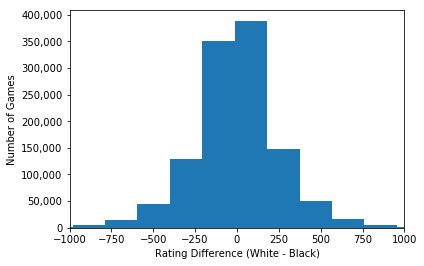

In [47]:
x = stats.RatingDiff
bins = 20
plt.hist(x, bins)
plt.xlabel('Rating Difference (White - Black)')
plt.ylabel('Number of Games')
#plt.title('Histogram of Rating Differences')
plt.xlim(-1000,1000)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [38]:
import matplotlib.ticker as ticker
#plt.FormatStrFormatter()
a = plt.gca()

#plt.ticklabel_format(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))), axis = 'y')

In [45]:
a = plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))

In [46]:
type(a)

matplotlib.ticker.FuncFormatter